### Imports

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [200]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

### Load data

In [4]:
train_features = pd.read_csv('data/train_features.csv')
train_targets = pd.read_csv('data/train_targets.csv')

test_features = pd.read_csv('data/test_features.csv')

### EDA

In [141]:
FEATURE_GASES = ['A_CH4', 'A_C2H6', 'A_C3H8', 'A_iC4H10', 'A_nC4H10', 'A_iC5H12', 'A_nC5H12', 'A_C6H14']
FEATURE_COLUMNS = ['A_rate', 'B_rate'] + FEATURE_GASES
TARGET_COLUMNS = ['B_C2H6', 'B_C3H8', 'B_iC4H10', 'B_nC4H10']

In [55]:
train_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-01-01 00:00:00,70.855017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.982789
1,2020-01-01 00:30:00,70.826582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.965098
2,2020-01-01 01:00:00,70.809637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.867409
3,2020-01-01 01:30:00,69.994748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.839126
4,2020-01-01 02:00:00,70.072762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.336921
...,...,...,...,...,...,...,...,...,...,...,...
5803,2020-04-30 21:30:00,72.009730,0.284151,4.936343,35.758852,16.473834,24.318968,6.069360,5.527463,6.577563,74.183355
5804,2020-04-30 22:00:00,71.854180,0.282501,4.960453,35.877193,16.448487,24.074193,5.981357,5.407256,6.915378,74.213066
5805,2020-04-30 22:30:00,71.783273,0.277686,5.013878,36.271557,16.500147,24.010123,5.829363,5.160329,6.884173,74.144367
5806,2020-04-30 23:00:00,71.717743,0.271106,5.080144,36.616673,16.559533,24.008848,5.750492,5.017941,6.642076,74.320575


In [56]:
train_targets

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-01-01 00:00:00,4.561979,39.015486,17.250740,24.301793
1,2020-01-01 00:30:00,4.550741,39.048915,17.229506,24.257461
2,2020-01-01 01:00:00,4.506793,38.766378,17.171621,24.236298
3,2020-01-01 01:30:00,4.584963,39.069360,17.218521,24.149843
4,2020-01-01 02:00:00,4.607483,38.817579,17.108668,24.049510
...,...,...,...,...,...
5803,2020-04-30 21:30:00,4.816865,35.539156,16.269938,24.770377
5804,2020-04-30 22:00:00,4.993286,36.067750,16.317757,24.729847
5805,2020-04-30 22:30:00,5.101574,36.275040,16.295460,24.629889
5806,2020-04-30 23:00:00,5.210675,36.872917,16.336359,24.438236


In [57]:
test_features

,timestamp,A_rate,A_CH4,A_C2H6,A_C3H8,A_iC4H10,A_nC4H10,A_iC5H12,A_nC5H12,A_C6H14,B_rate
0,2020-05-01 00:00:00,71.428342,0.267832,5.135159,36.816480,16.632260,24.062587,5.696004,4.939430,6.395286,74.273009
1,2020-05-01 00:30:00,70.925118,0.268464,5.149646,36.869023,16.651870,24.069800,5.676384,4.911872,6.346957,74.061833
2,2020-05-01 01:00:00,70.991719,0.270641,5.154615,37.074965,16.710967,24.106152,5.574873,4.808516,6.242636,73.856268
3,2020-05-01 01:30:00,70.972406,0.275241,5.230661,37.384180,16.683337,24.021993,5.514843,4.730887,6.101647,73.750744
4,2020-05-01 02:00:00,70.980078,0.275062,5.241437,37.448587,16.663863,24.003237,5.524898,4.728882,6.057119,73.698447
...,...,...,...,...,...,...,...,...,...,...,...
3979,2020-07-22 21:30:00,72.600912,0.120985,4.328092,40.875930,17.741460,24.098520,4.469224,3.619095,4.686205,75.486026
3980,2020-07-22 22:00:00,72.107049,0.110734,4.013567,38.871418,17.449352,24.049532,4.770699,3.988215,6.689777,75.370451
3981,2020-07-22 22:30:00,71.805799,0.111535,4.041506,39.794323,17.635380,24.169473,4.613603,3.790651,5.785216,74.985878
3982,2020-07-22 23:00:00,72.112046,0.119362,4.131432,40.461503,17.758833,24.211013,4.504242,3.657459,5.094626,74.766867


#### Series plotting

In [58]:
def plot_series(df, layout=None, figsize=(15,15)):
    df.plot(kind='line', subplots=True, grid=True, layout=layout, sharex=True, figsize=figsize)

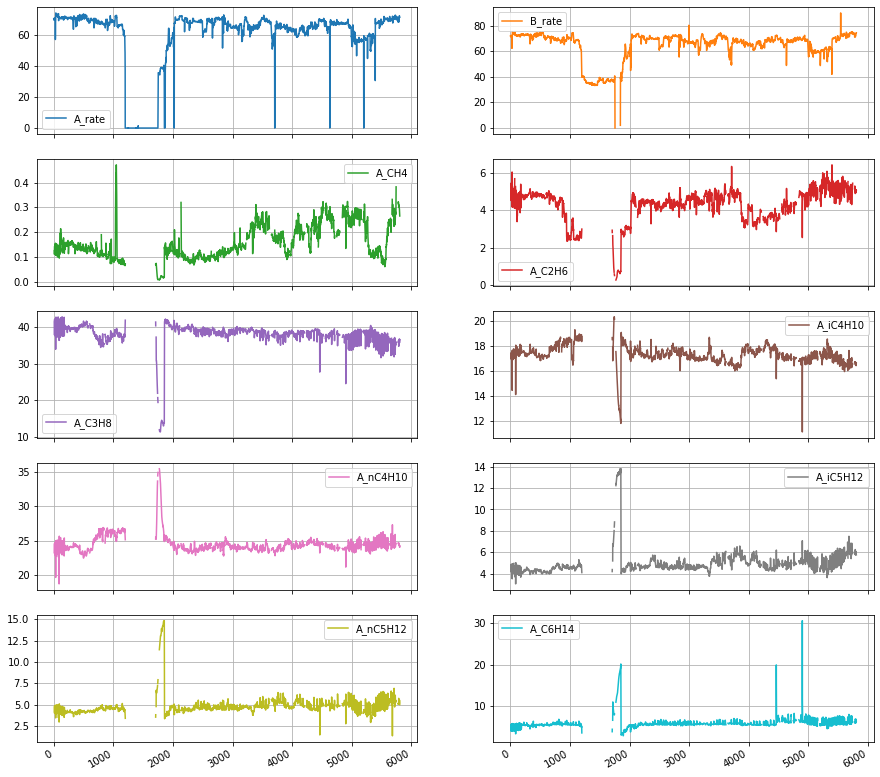

In [59]:
plot_series(train_features[FEATURE_COLUMNS], layout=(5,2))

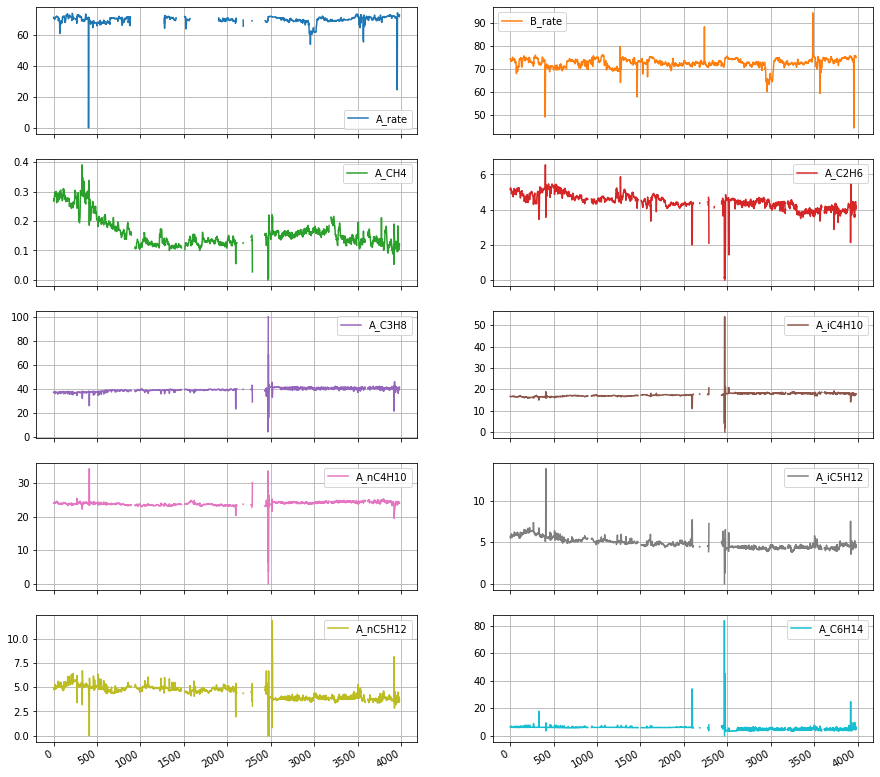

In [60]:
plot_series(test_features[FEATURE_COLUMNS], layout=(5,2))

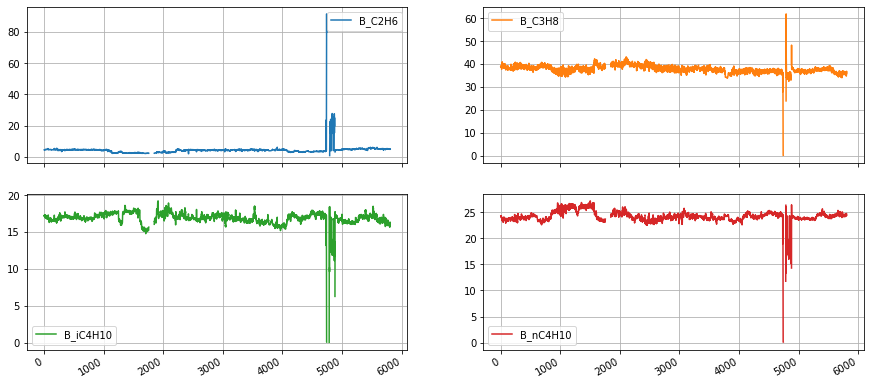

In [61]:
plot_series(train_targets[TARGET_COLUMNS], layout=(2,2), figsize=(15, 7))

#### Rates visual comparison

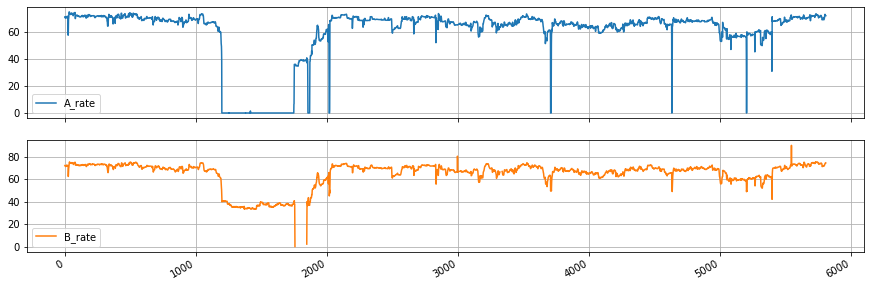

In [62]:
plot_series(train_features[['A_rate', 'B_rate']], figsize=(15,5))

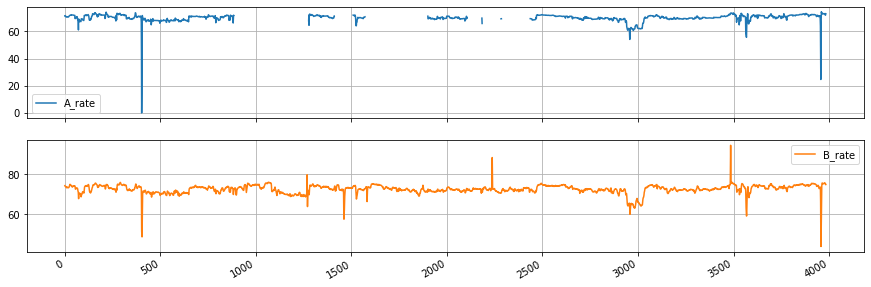

In [63]:
plot_series(test_features[['A_rate', 'B_rate']], figsize=(15,5))

#### Diff of rates

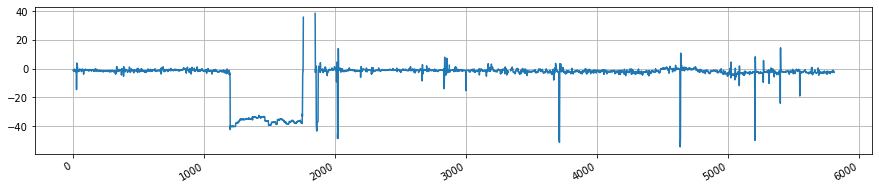

In [64]:
plot_series(train_features[['A_rate', 'B_rate']].apply(lambda x: x[0]-x[1], axis=1), figsize=(15,3))

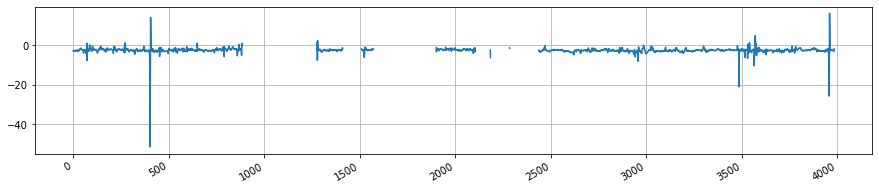

In [65]:
plot_series(test_features[['A_rate', 'B_rate']].apply(lambda x: x[0]-x[1], axis=1), figsize=(15,3))

#### Total compaund of gases

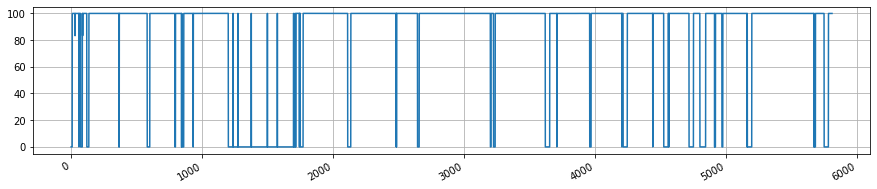

In [80]:
plot_series(train_features[FEATURE_GASES].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

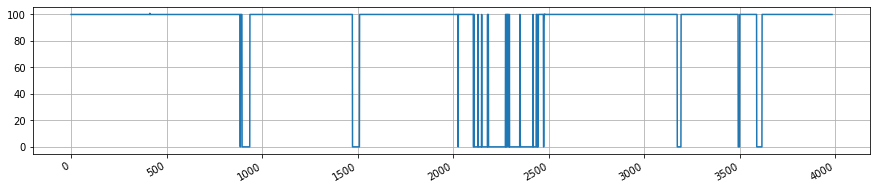

In [81]:
plot_series(test_features[FEATURE_GASES].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

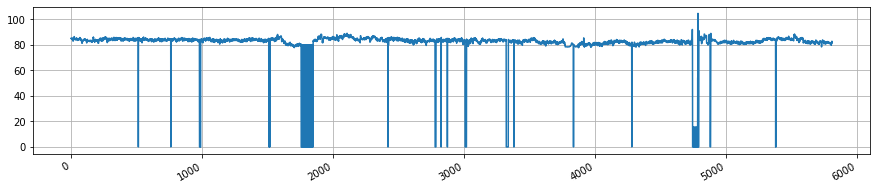

In [145]:
plot_series(train_targets[TARGET_COLUMNS].apply(lambda x: x.sum(), axis=1), figsize=(15,3))

In [152]:
def show_feature_gas_missmatch(df, delta=1):
    gases_sum_df = df[FEATURE_GASES].apply(lambda x: x.sum(), axis=1)
    print('Missmatch, %')
    print(gases_sum_df[(gases_sum_df < 100-delta) & (gases_sum_df > delta)])
    print('\n')
    print('Missmatch points')
    print(df[(gases_sum_df < 100-delta) & (gases_sum_df > delta)])

In [153]:
show_feature_gas_missmatch(train_features)

Missmatch, %
30    83.284430
88    83.281805
dtype: float64


Missmatch points
              timestamp     A_rate     A_CH4   A_C2H6     A_C3H8   A_iC4H10  \
30  2020-01-01 15:00:00  70.825458  0.107138  4.17248  33.986153  14.468455   
88  2020-01-02 20:00:00  71.763913  0.109018  4.47591  36.520668  14.133945   

     A_nC4H10  A_iC5H12  A_nC5H12   A_C6H14     B_rate  
30  19.601260  3.508229  3.442494  3.998220  69.986659  
88  18.655932  3.033678  2.954645  3.398009  72.871169  


In [154]:
show_feature_gas_missmatch(test_features)

Missmatch, %
2350     4.148695
2351     4.167530
2475    93.473273
dtype: float64


Missmatch points
                timestamp     A_rate     A_CH4    A_C2H6     A_C3H8  A_iC4H10  \
2350  2020-06-18 23:00:00        NaN       NaN  4.148695        NaN       NaN   
2351  2020-06-18 23:30:00        NaN       NaN  4.167530        NaN       NaN   
2475  2020-06-21 13:30:00  71.936886  0.005033  0.078523  68.149836  2.007036   

      A_nC4H10  A_iC5H12  A_nC5H12    A_C6H14     B_rate  
2350       NaN       NaN       NaN        NaN  71.394341  
2351       NaN       NaN       NaN        NaN  71.518385  
2475   3.73648  1.316491   1.72344  16.456435  74.206501  


In [181]:
def show_target_gas_missmatch(df, target_sum=85, delta=5):
    gases_sum_df = df[TARGET_COLUMNS].apply(lambda x: x.sum(), axis=1)
    print('Missmatch, %')
    mask = ((gases_sum_df < target_sum-delta) & (gases_sum_df > 0.0)) | (gases_sum_df > target_sum+delta)
    print(gases_sum_df[mask])
    print('\n')
    print('Missmatch points')
    print(df[mask])

In [182]:
show_target_gas_missmatch(train_targets, delta=10)

Missmatch, %
4748     15.514087
4754     15.514087
4760     15.514087
4766     15.514087
4772     15.514087
4778     15.514087
4782     54.315387
4784    104.705157
4790     51.736505
4881     63.719634
dtype: float64


Missmatch points
                timestamp     B_C2H6     B_C3H8   B_iC4H10   B_nC4H10
4748  2020-04-08 22:00:00  15.455240   0.026142   0.012764   0.019941
4754  2020-04-09 01:00:00  15.455240   0.026142   0.012764   0.019941
4760  2020-04-09 04:00:00  15.455240   0.026142   0.012764   0.019941
4766  2020-04-09 07:00:00  15.455240   0.026142   0.012764   0.019941
4772  2020-04-09 10:00:00  15.455240   0.026142   0.012764   0.019941
4778  2020-04-09 13:00:00  15.455240   0.026142   0.012764   0.019941
4782  2020-04-09 15:00:00  54.095680   0.099073   0.046072   0.074563
4784  2020-04-09 16:00:00  46.368060  46.527746   0.039690  11.769661
4790  2020-04-09 19:00:00   4.325312  23.913870  10.111635  13.385687
4881  2020-04-11 16:30:00   3.492313  39.656436   6.269465  14.

#### Measure Nan

In [186]:
train_targets.iloc[1800:1820, :]

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
1800,2020-02-07 12:00:00,NaN,NaN,NaN,NaN
1801,2020-02-07 12:30:00,NaN,NaN,NaN,NaN
1802,2020-02-07 13:00:00,NaN,NaN,NaN,NaN
1803,2020-02-07 13:30:00,2.363416,38.25387,15.61444,23.70408
1804,2020-02-07 14:00:00,NaN,NaN,NaN,NaN
1805,2020-02-07 14:30:00,NaN,NaN,NaN,NaN
1806,2020-02-07 15:00:00,NaN,NaN,NaN,NaN
1807,2020-02-07 15:30:00,NaN,NaN,NaN,NaN
1808,2020-02-07 16:00:00,NaN,NaN,NaN,NaN
1809,2020-02-07 16:30:00,2.363416,38.25387,15.61444,23.70408


In [187]:
train_targets.iloc[4748:4790, :]

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
4748,2020-04-08 22:00:00,15.45524,0.026142,0.012764,0.019941
4749,2020-04-08 22:30:00,NaN,NaN,NaN,NaN
4750,2020-04-08 23:00:00,NaN,NaN,NaN,NaN
4751,2020-04-08 23:30:00,NaN,NaN,NaN,NaN
4752,2020-04-09 00:00:00,NaN,NaN,NaN,NaN
4753,2020-04-09 00:30:00,NaN,NaN,NaN,NaN
4754,2020-04-09 01:00:00,15.45524,0.026142,0.012764,0.019941
4755,2020-04-09 01:30:00,NaN,NaN,NaN,NaN
4756,2020-04-09 02:00:00,NaN,NaN,NaN,NaN
4757,2020-04-09 02:30:00,NaN,NaN,NaN,NaN


### Fill NA

- gas NaNs (where all NaN and where not all): 
- rates NaNs
- targets Nans

In [220]:
#basis ffill + bfill

X_train = train_features.fillna(method='ffill').fillna(method='bfill') #both directions
y_train = train_targets.fillna(method='ffill').fillna(method='bfill') #both directions
# X_test = test_features.fillna(method='ffill').fillna(method='bfill') #NOT VALID WITHIN RULES
X_test = test_features.fillna(method='ffill')# just forward direction

### Modelling

In [258]:
def plot_fitted_values(estimator, X, y_true, title):
    y_pred = estimator.predict(X)
    _, ax = plt.subplots(1, 1, figsize=(15, 3))

    ax.plot(y_true, label="true")
    ax.plot(y_pred, label="prediction")
    ax.legend()
    ax.set_title(title)

In [259]:
def evaluate_training(X_train, y_train):
    results = []
    for target in TARGET_COLUMNS:
        model_pipline = Pipeline([
        ("regressor", Ridge())
        ])

        params_grid = {
            "regressor__alpha": np.logspace(-8, 3, num=12, base=10),
            "regressor__fit_intercept": [True, False],
        }



        model = GridSearchCV(model_pipline, 
                            params_grid, 
                            scoring=make_scorer(mean_absolute_error), 
                            n_jobs=-1,
                            cv=10,
                            verbose=1,
                            refit=True,
                            return_train_score=True
                            )


        model.fit(X_train[FEATURE_COLUMNS], y_train[target])

        results.append(model)
    
    return {target: model for target, model in zip(TARGET_COLUMNS, results)}

    

In [264]:
results = evaluate_training(X_train[FEATURE_COLUMNS], y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
Fitting 10 folds for each of 24 candidates, totalling 240 fits
[Parallel(n_jobs=-1)]: Done 100 tasks      | 

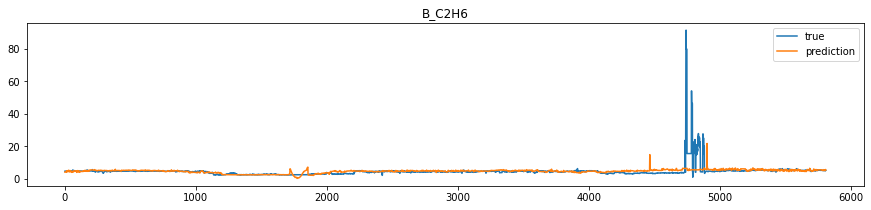

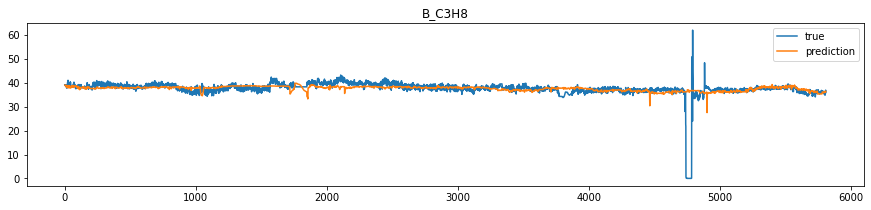

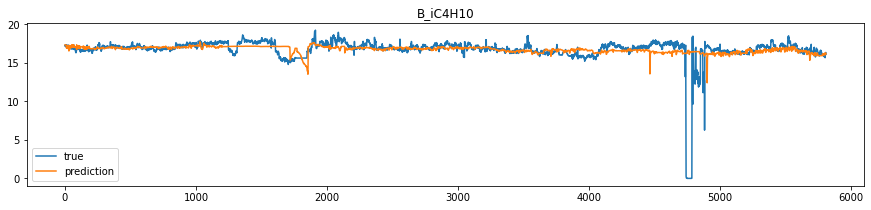

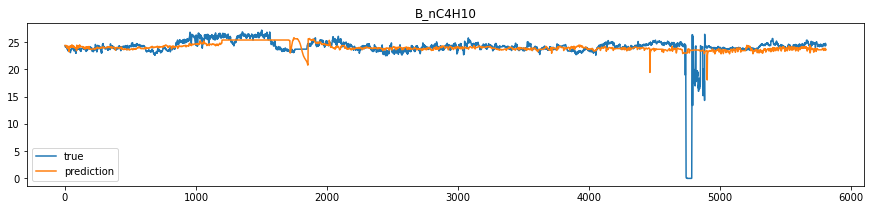

In [262]:
for target, model in results.items():
    plot_fitted_values(model.best_estimator_, X_train[FEATURE_COLUMNS], y_train[target], target)


In [282]:
submission = test_features['timestamp'].values.reshape(-1, 1)
for target, model in results.items():
    y_pred = model.predict(X_test[FEATURE_COLUMNS])
    submission = np.concatenate((submission, y_pred.reshape(-1, 1)), axis=1)
    
submission_df = pd.DataFrame(submission, columns=['timestamp'] + TARGET_COLUMNS)
submission_df

,timestamp,B_C2H6,B_C3H8,B_iC4H10,B_nC4H10
0,2020-05-01 00:00:00,5.3545,36.3546,16.2085,23.6526
1,2020-05-01 00:30:00,5.33754,36.3653,16.2129,23.6667
2,2020-05-01 01:00:00,5.324,36.3924,16.2496,23.7079
3,2020-05-01 01:30:00,5.28747,36.4423,16.2814,23.7497
4,2020-05-01 02:00:00,5.24574,36.4804,16.295,23.7728
...,...,...,...,...,...
3979,2020-07-22 21:30:00,4.23606,38.1803,17.0225,24.3318
3980,2020-07-22 22:00:00,5.44355,37.2898,16.6046,23.6972
3981,2020-07-22 22:30:00,4.84566,37.7098,16.8196,24.0322
3982,2020-07-22 23:00:00,4.43754,37.9704,16.9525,24.2442


In [285]:
submission_df.to_csv('submission.csv', index=False)